In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import os
from astropy import wcs
from astropy.table import Table, hstack, Column
from astropy.utils.console import ProgressBar
#import seaborn as sns
import pandas as pd

In [12]:
# Image information and assumptions
distance        = 8340. # distance to GC; Reid et al. 2014
#Temp            = 20.0
Wave            = (3.0e8/226.e9)
Wave0           = 1.3e-3
k0              = 0.899
nu              = 3.e08/Wave
nu0             = 3.e08/Wave0
beta            = 1.75
Kappag2d        = k0*((nu/nu0)**beta)
g2d             = 100.0
Kappa           = Kappag2d / g2d
mu              = 2.8 # express everything in H2

dustTemp = 20

# Constants
G = 6.67408e-11
msun = 1.989e33
mh = 1.6737236e-27
pc2cm = 3.08567758e18
as2persr = 4.25e10 
percm2perm = 1.0e6
JyperSr_to_JyperPix = (3.0462*(10**-4))*((0.00013888888888)**2)
JyperSr_to_Jyperassqr = ((np.pi*180.)**(-2))*(3600**(-1))
hplanck = 6.63e-34
clight = 2.99792e8
kboltzmann = 1.381e-23
sin1yr = 3.15569e7
arcsec2pc = distance/((360./(2.*np.pi))*60.*60.)

def planck_wave( Wave, Temp ):

    # Planck function using wavelength

    planck_conv_wave = 1.e-26 * clight / Wave**2.0

    planck = ((2.0*hplanck*clight**2.0)/(Wave**5.0))*(1.0/(np.exp((hplanck*clight)/(Wave*kboltzmann*Temp))-1.0))
    planck = planck/planck_conv_wave

    return planck

def mass_calc_submm( Wave, Temp, Kappa, Integrated_Flux, Obj_Dist ):

    Obj_Dist = Obj_Dist * pc2cm
    #from planck_func import planck_wave
    B = planck_wave( Wave, Temp )
    Mass = (Obj_Dist**2. * Integrated_Flux) / ( Kappa * B )
    Mass = Mass / msun
    return Mass

In [15]:
### Load tables

targetname = '_rms4e6_dv3_dd3_dp20_pp6_pm2_gal_sept_24_2018.fits'
target_id = targetname
path = os.path.expanduser('~/catalog_sept_24/')
catalog = Table.read(path+'master_tab'+targetname)
df = catalog.to_pandas()
tff_spherical = catalog['tff']
mass = catalog['mass']
mass_bgsub = catalog['mass_bgsub']
r_eff_as = catalog['r_eff']
r_eff_pc = r_eff_as * arcsec2pc
flux_integrated = catalog['flux_integrated']
noise_JySr = catalog['noise']
noise_Jyas = noise_JySr / as2persr
noise = noise_Jyas * catalog['area_exact']
flux_integrated = catalog['flux_integrated']
noise_mass = mass_calc_submm(Wave, dustTemp, Kappa, noise, distance)

In [18]:
df.columns

Index([u'index', u'area_ellipse', u'area_exact', u'flux_integrated',
       u'major_sigma', u'minor_sigma', u'position_angle', u'radius', u'glon',
       u'glat', u'r_eff', u'testflux_integrated', u'is_leaf', u'noise',
       u'flux_integrated_bgsub', u'npix', u'mean_cont_flux',
       u'min_flux_integrated', u'peak_cont_flux', u'min_cont_flux',
       u'ColumnDensity', u'mass', u'N', u'Sigma', u'n', u'rho', u'tff',
       u'glon_0', u'mass_bgsub', u'YSO', u'HII', u'Water', u'Methanol', u'OH',
       u'8micron', u'24micron', u'70micron', u'Notes', u'sum_all',
       u'sum_sf_tracers', u'Total_luminosity', u'Cool_luminosity',
       u'Warm_luminosity', u'Cool_dust_temp', u'H2CO_gas_temp'],
      dtype='object')

In [10]:
### setup columns

gastemps = catalog['H2CO_gas_temp']
rgt = gastemps[np.isfinite(gastemps)]
water = catalog['Water'][np.isfinite(gastemps)]
oh = catalog['OH'][np.isfinite(gastemps)]
meth = catalog['Methanol'][np.isfinite(gastemps)]
ir8u = catalog['8micron'][np.isfinite(gastemps)]
ir24u = catalog['24micron'][np.isfinite(gastemps)]
ir70u = catalog['70micron'][np.isfinite(gastemps)]
yso = catalog['YSO'][np.isfinite(gastemps)]
meth = catalog['Methanol'][np.isfinite(gastemps)]
HII = catalog['HII'][np.isfinite(gastemps)]


print(len(rgt))
HII_tot = np.array(HII,dtype=float)
maser_tot = np.array(water,dtype=float)+np.array(oh,dtype=float)+np.array(meth,dtype=float)
ir_yso_tot = np.array(ir8u,dtype=float)+np.array(ir24u,dtype=float)+np.array(ir70u,dtype=float)+np.array(yso,dtype=float)
all_tot = maser_tot + ir_yso_tot + HII_tot

for i in range(len(HII_tot)):
    if maser_tot[i]>0: maser_tot[i]=1
    if ir_yso_tot[i]>0: ir_yso_tot[i]=1
    if HII_tot[i]>0: HII_tot[i]=1

#rgt_masers = rgt[(water!=0)|(meth!=0)|(oh!=0)]
rgt_masers = rgt[maser_tot>0]
rgt_no_masers = rgt[maser_tot==0]
rgt_HII = rgt[HII>0]
rgt_no_masers = rgt[maser_tot==0]
print len(rgt_masers) + len(rgt_no_masers)
rgt_ir_yso = rgt[ir_yso_tot>0]
rgt_no_ir_yso = rgt[ir_yso_tot==0]
print len(rgt_ir_yso) + len(rgt_no_ir_yso)
rgt_tot = rgt[all_tot>0]
rgt_no_tot = rgt[all_tot==0]
print len(rgt_tot) + len(rgt_no_tot)

### define histogram subsets



NameError: name 'table_hdu' is not defined

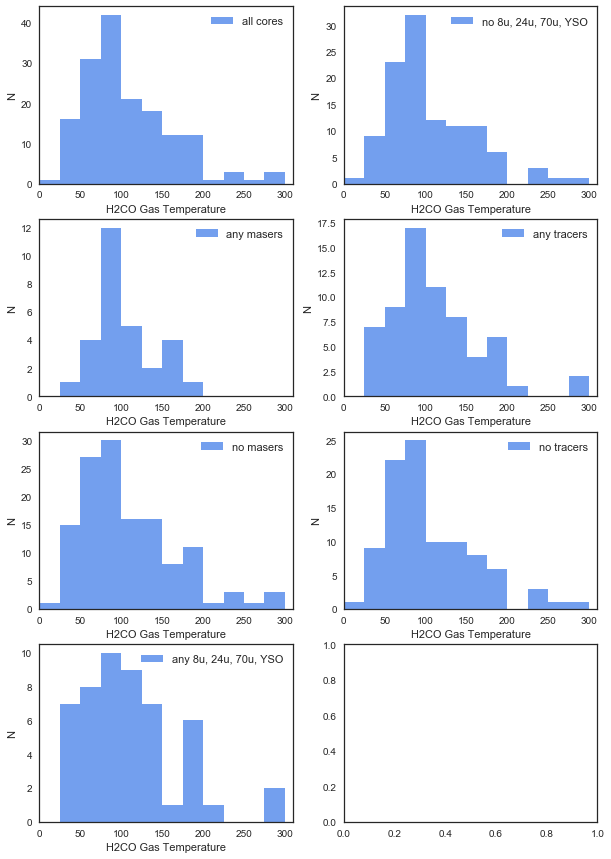

In [134]:
plt.close()
fig, axs = plt.subplots(4,2,figsize=(10,15))

gt_bins = np.linspace(0,350,15)
histcolor = 'cornflowerblue'
histalpha =0.9

axs[0,0].hist(rgt,bins=gt_bins,label="all cores",color=histcolor,alpha=histalpha)
axs[0,0].set_xlabel('H2CO Gas Temperature')
axs[0,0].set_xlim(0,310)
axs[0,0].set_ylabel('N')
axs[0,0].legend(loc='upper right', shadow=False, fontsize=11)

axs[1,0].hist(rgt_masers,bins=gt_bins,label="any masers",color=histcolor,alpha=histalpha)
axs[1,0].set_xlabel('H2CO Gas Temperature')
axs[1,0].set_ylabel('N')
axs[1,0].set_xlim(0,310)
axs[1,0].legend(loc='upper right', shadow=False, fontsize=11)

axs[2,0].hist(rgt_nomasers,bins=gt_bins,label="no masers",color=histcolor,alpha=histalpha)
axs[2,0].set_xlabel('H2CO Gas Temperature')
axs[2,0].set_ylabel('N')
axs[2,0].set_xlim(0,310)
axs[2,0].legend(loc='upper right', shadow=False, fontsize=11)

axs[3,0].hist(rgt_ir_yso,bins=gt_bins,label="any 8u, 24u, 70u, YSO",color=histcolor,alpha=histalpha)
axs[3,0].set_xlabel('H2CO Gas Temperature')
axs[3,0].set_ylabel('N')
axs[3,0].set_xlim(0,310)
axs[3,0].legend(loc='upper right', shadow=False, fontsize=11)

axs[0,1].hist(rgt_no_ir_yso,bins=gt_bins,label="no 8u, 24u, 70u, YSO",color=histcolor,alpha=histalpha)
axs[0,1].set_xlabel('H2CO Gas Temperature')
axs[0,1].set_ylabel('N')
axs[0,1].set_xlim(0,310)
axs[0,1].legend(loc='upper right', shadow=False, fontsize=11)

axs[1,1].hist(rgt_tot,bins=gt_bins,label="any tracers",color=histcolor,alpha=histalpha)
axs[1,1].set_xlabel('H2CO Gas Temperature')
axs[1,1].set_ylabel('N')
axs[1,1].set_xlim(0,310)
axs[1,1].legend(loc='upper right', shadow=False, fontsize=11)

axs[2,1].hist(rgt_no_tot,bins=gt_bins,label="no tracers",color=histcolor,alpha=histalpha)
axs[2,1].set_xlabel('H2CO Gas Temperature')
axs[2,1].set_ylabel('N')
axs[2,1].set_xlim(0,310)
axs[2,1].legend(loc='upper right', shadow=False, fontsize=11)

plt.show()


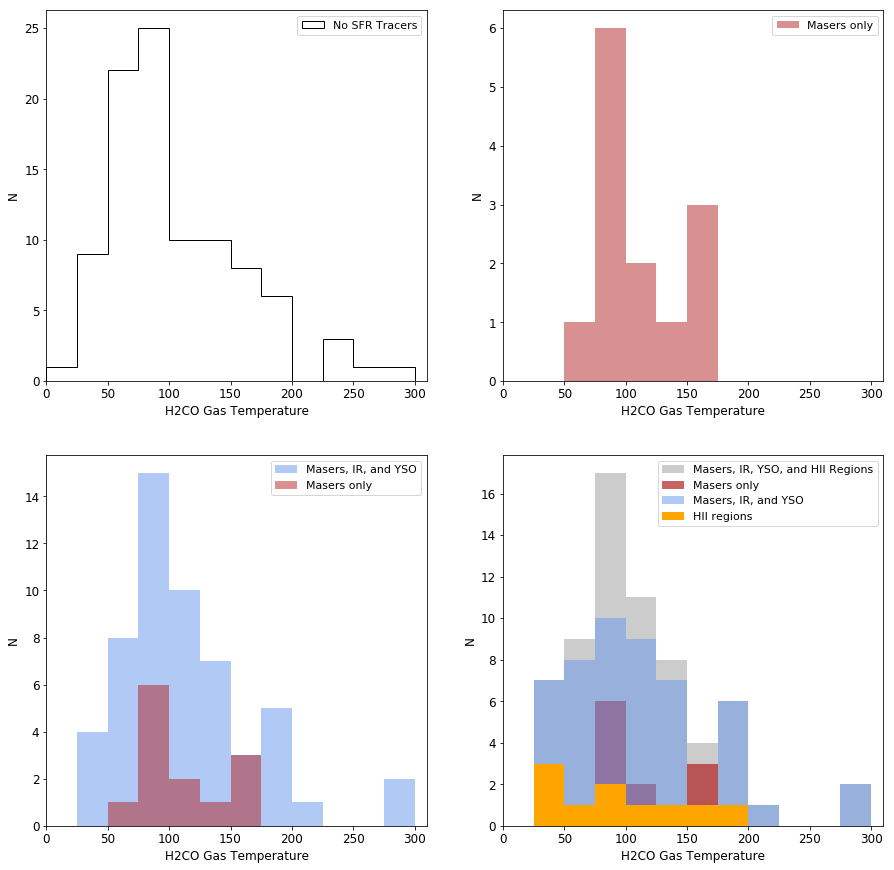

In [28]:
plt.close()

HII_tot = np.array(HII,dtype=float)
maser_tot = (np.array(water,dtype=float)+
             np.array(oh,dtype=float)+np.array(meth,dtype=float))
ir_yso_tot = (np.array(ir8u,dtype=float)+
              np.array(ir24u,dtype=float)+
              np.array(ir70u,dtype=float)+
              np.array(yso,dtype=float))
all_tot = maser_tot + ir_yso_tot + HII_tot

for i in range(len(HII_tot)):
    if maser_tot[i]>0: maser_tot[i]=1
    if ir_yso_tot[i]>0: ir_yso_tot[i]=1
    if HII_tot[i]>0: HII_tot[i]=1

fig, axs = plt.subplots(2,2,figsize=(15,15))

gt_bins = np.linspace(0,350,15)
histcolor = 'cornflowerblue'
histalpha =0.5

rgt_none = rgt[(maser_tot + ir_yso_tot + HII_tot) ==0]
rgt_masers_only = rgt[(maser_tot>0) & ((ir_yso_tot + HII_tot)==0)]
rgt_masers_all = rgt[(maser_tot>0)]
rgt_masers_iryso = rgt[(maser_tot + ir_yso_tot>0) & (HII_tot==0)]
rgt_iryso_only = rgt[(ir_yso_tot>0) & (maser_tot+ HII_tot==0)]
rgt_iryso_all = rgt[(ir_yso_tot>0)]
rgt_HII_all = rgt[(HII_tot>0)]
rgt_HII_only = rgt[(maser_tot==0) & (ir_yso_tot==0) & (HII_tot>0)]
rgt_masers_iryso_HII = rgt[(maser_tot + ir_yso_tot + HII_tot)>0]

axs[0,0].hist(rgt_none,bins=gt_bins,label="No SFR Tracers",color='black',histtype='step')
axs[0,0].set_xlabel('H2CO Gas Temperature')
axs[0,0].set_xlim(0,310)
axs[0,0].set_ylabel('N')
axs[0,0].legend(loc='upper right', shadow=False, fontsize=11)

#axs[0,1].hist(rgt_none,bins=gt_bins,label="No SFR Tracers",color='black',alpha=1.,histtype='step')
axs[0,1].hist(rgt_masers_only,bins=gt_bins,label="Masers only",color='firebrick',alpha=histalpha)
axs[0,1].set_xlabel('H2CO Gas Temperature')
axs[0,1].set_ylabel('N')
axs[0,1].set_xlim(0,310)
axs[0,1].legend(loc='upper right', shadow=False, fontsize=11)

#axs[1,0].hist(rgt_none,bins=gt_bins,label="No SFR Tracers",color='black',alpha=1.,histtype='step')
axs[1,0].hist(rgt_masers_iryso,bins=gt_bins,label="Masers, IR, and YSO",alpha=0.5,color=histcolor,histtype='stepfilled')
axs[1,0].hist(rgt_masers_only,bins=gt_bins,label="Masers only",color='firebrick',alpha=histalpha)
#axs[1,0].hist(rgt_iryso_only,bins=gt_bins,label="Masers, IR, and YSO",color=histcolor,alpha=0.5)
axs[1,0].set_xlabel('H2CO Gas Temperature')
axs[1,0].set_ylabel('N')
axs[1,0].set_xlim(0,310)
axs[1,0].legend(loc='upper right', shadow=False, fontsize=11)

#axs[1,1].hist(rgt_none,bins=gt_bins,label="No SFR Tracers",color='black',alpha=1.,histtype='step')
axs[1,1].hist(rgt_masers_iryso_HII,bins=gt_bins,label="Masers, IR, YSO, and HII Regions",color='black',alpha=0.2)
axs[1,1].hist(rgt_masers_only,bins=gt_bins,label="Masers only",color='firebrick',alpha=0.7)
axs[1,1].hist(rgt_iryso_all,bins=gt_bins,label="Masers, IR, and YSO",color=histcolor,alpha=0.5)
axs[1,1].hist(rgt_HII_all,bins=gt_bins,label="HII regions",color='orange',alpha=1.)
axs[1,1].set_xlabel('H2CO Gas Temperature')
axs[1,1].set_ylabel('N')
axs[1,1].set_xlim(0,310)
axs[1,1].legend(loc='upper right', shadow=False, fontsize=11)

plt.show()


(3, 4)
3


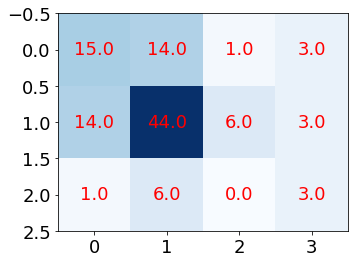

In [18]:
### building comparison matrix for all permutations of Masers, YSO+IR and HII
#sns.set_style('white')
### 0 = maser, 1 = yso+IR, 2 = HII
all_maser = np.array(catalog['Water'],dtype=float) + np.array(catalog['Methanol'],dtype=float) + np.array(catalog['OH'],dtype=float)
all_iryso = np.array(catalog['8micron'],dtype=float) + np.array(catalog['24micron'],dtype=float) + np.array(catalog['70micron'],dtype=float) + np.array(catalog['YSO'],dtype=float)
all_HII = np.array(catalog['HII'],dtype=float)

for i in range(len(all_maser)):
    if all_maser[i]>0: all_maser[i]=1
    if all_iryso[i]>0: all_iryso[i]=1
    if all_HII[i]>0: all_HII[i]=1
        
all_list = [all_maser,all_iryso,all_HII]

### initialize matrix
comp_matrix = np.zeros((len(all_list),len(all_list)+1),dtype=float)
print comp_matrix.shape

all_together = sum((all_list[0]>0) & (all_list[1]>0) & (all_list[2]>0))
print all_together

# for i in range(3):
#     comp_matrix[i,3] = all_together
#     for j in range(3):
#         num = sum((all_list[i]>0) & (all_list[j]>0) )
#         comp_matrix[i,j]=num

comp_matrix[0,0] = sum((all_list[0]>0) & (all_list[1]==0) & (all_list[2]==0))
comp_matrix[1,1] = sum((all_list[1]>0) & (all_list[0]==0) & (all_list[2]==0))
comp_matrix[2,2] = sum((all_list[2]>0) & (all_list[0]==0) & (all_list[1]==0))
comp_matrix[0,1] = sum((all_list[0]>0) & (all_list[1]>0) & (all_list[2]==0))
comp_matrix[0,2] = sum((all_list[0]>0) & (all_list[2]>0) & (all_list[1]==0))
comp_matrix[1,2] = sum((all_list[1]>0) & (all_list[2]>0) & (all_list[0]==0))
comp_matrix[0,3] = sum((all_list[0]>0) & (all_list[1]>0) & (all_list[2]>0))
comp_matrix[1,0], comp_matrix[2,0], comp_matrix[2,1] = comp_matrix[0,1], comp_matrix[0,2], comp_matrix[1,2]
comp_matrix[1,3] = comp_matrix[0,3]
comp_matrix[2,3] = comp_matrix[0,3]

ax=plt.gca()
for i in range(len(comp_matrix[:,0])):
    for j in range(len(comp_matrix[0,:])):
        text = ax.text(j, i, comp_matrix[i, j],
                       ha="center", va="center", color="red")

plt.imshow(comp_matrix,cmap='Blues')
plt.show()

In [133]:
print sum(all_list[2])
print sum((all_list[2]>0) & (all_list[1]>0))
print sum((all_list[2]>0) & (all_list[0]>0))
print comp_matrix[2,2]

10.0
9
4
0.0


(2,)
(2,)


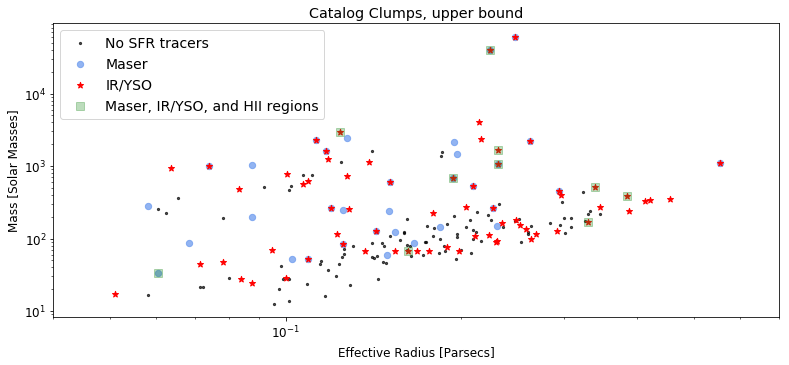

In [48]:
### Lets redo the MR plot but labeled with SF tracers:

def radius_from_mass_const_col_density(Mass_solar,col_dens):
    #print Mass_solar
    Mass = Mass_solar * (msun/1000.0)
    #print Mass
    col_dens = col_dens * (10**4) #convert from cm^-2 to m^-2

    Radius_sqrd = (Mass / (mu * mh * col_dens)) / (np.pi)
    #print Radius_cubed
    Radius_cm = Radius_sqrd**(1./2.)
    #print Radius_cm
    Radius_pc = Radius_cm / (pc2cm/100)
    return Radius_pc
   
    
def mass_from_radius_const_col_density(Radius_pc,col_dens):
    Radius_cm = Radius_pc * (pc2cm)#/100) 
    Radius_sqrd = Radius_cm**2
    Mass = Radius_sqrd * (np.pi) * (mu * mh * col_dens)
    col_dens = col_dens * (10**4) #convert from cm^-2 to m^-2
    Mass_solar = Mass / (msun/1000.0)
    return Mass_solar

plt.close()
plt.rcParams.update({'font.size': 12}) #set fontsize
mrfig = plt.figure(3,figsize=(13,6))
mrfig.clf()
ax = mrfig.gca()
plt.xlabel('Effective Radius [Parsecs]')
plt.ylabel('Mass [Solar Masses]')
ax.set_title('Catalog Clumps, upper bound')
pcolor = 'tomato'

### conditions
none_cond = (all_maser+all_iryso+all_HII) == 0
maser_cond = (all_maser>0)
iryso_cond = (all_iryso>0)
HII_cond = (all_HII>0)

ax.scatter(r_eff_pc[none_cond], mass[none_cond],s=20, 
           color='black',marker='.',alpha=.7,label='No SFR tracers')
ax.scatter(r_eff_pc[maser_cond], mass[maser_cond],s=40, 
           color='cornflowerblue',marker='o',alpha=.7,label='Maser')
ax.scatter(r_eff_pc[iryso_cond], mass[iryso_cond],s=40, 
           color='red',marker='*',alpha=1.,label='IR/YSO')
ax.scatter(r_eff_pc[HII_cond], mass[HII_cond],s=60, 
           color='forestgreen',marker='s',alpha=.3,label='Maser, IR/YSO, and HII regions')

#ax.errorbar(x=r_eff_pc, y=mass, yerr=noise_mass, ls='none',color=pcolor,alpha=1.)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(4e-2,0.7)

plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis
mass_bin = np.array([min(mass),max(mass)])
print mass_bin.shape
radius_vals = radius_from_mass_const_col_density(mass_bin,2.1*10**23)
print radius_vals.shape
#ax.plot(radius_vals,mass_bin,color='navy',
#        label='Constant Column Density of 2.1*10$^{23}$ cm$^{-2}$',linestyle='-',alpha=0.5)

legend = plt.legend(loc='upper left', shadow=False, fontsize=14)#'x-large')

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
#plt.savefig(figure_path + 'no_line_mass_radius'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()

In [58]:
print sf_cond.shape

(161,)


In [59]:
### Herschel pdf but with SF tracers
import reproject
import pyregion

all_maser = np.array(catalog['Water'],dtype=float) + np.array(catalog['Methanol'],dtype=float) + np.array(catalog['OH'],dtype=float)
all_iryso = np.array(catalog['8micron'],dtype=float) + np.array(catalog['24micron'],dtype=float) + np.array(catalog['70micron'],dtype=float) + np.array(catalog['YSO'],dtype=float)
all_HII = np.array(catalog['HII'],dtype=float)

for i in range(len(all_maser)):
    if all_maser[i]>0: all_maser[i]=1
    if all_iryso[i]>0: all_iryso[i]=1
    if all_HII[i]>0: all_HII[i]=1

all_tracers = all_maser + all_iryso + all_HII

sf_cond = (all_tracers > 0)
nsf_cond = (all_tracers ==0)

### Make figure of column density 
column_file = os.path.join(path, 'column_properunits_conv36_source_only.fits')
sma_file = os.path.join(path, 'Continuum_mosaic_current_no_sgra_no_IHMSFR.fits')
sma_mosaic = fits.open(sma_file)
sma_orig = sma_mosaic[0].data
sma_observed = np.isfinite(sma_orig)

# column density file handle
column_fh = fits.open(column_file)
column_masked = column_fh[0].data

smaobserved_projto_herschel,_ = reproject.reproject_interp((sma_observed,
                                                            wcs.WCS(sma_mosaic[0].header).celestial),
                                                            column_fh[0].header)
smaobserved_projto_herschel[np.isnan(smaobserved_projto_herschel)] = 0
smaobserved_projto_herschel = smaobserved_projto_herschel.astype('bool')
colwcs = wcs.WCS(column_fh[0].header)

pix = colwcs.wcs_world2pix(catalog['glon'], catalog['glat'], 0)
pix_nsf = colwcs.wcs_world2pix(catalog['glon'][nsf_cond], catalog['glat'][nsf_cond], 0)
pix_sf = colwcs.wcs_world2pix(catalog['glon'][sf_cond], catalog['glat'][sf_cond], 0)

column_dens = column_fh[0].data[pix[1].astype('int'), pix[0].astype('int')]
column_dens_nsf = column_fh[0].data[pix_nsf[1].astype('int'), pix_nsf[0].astype('int')]
column_dens_sf = column_fh[0].data[pix_sf[1].astype('int'), pix_sf[0].astype('int')]

column_masked[~smaobserved_projto_herschel] = np.nan


sb2_mask = pyregion.open(os.path.join('/Users/hph/Dropbox/CMZoom_Data/prototype_catalog/', 'sgrb2mask.reg')).get_mask(column_fh[0])

colmin = np.nanmin(column_masked[~sb2_mask])
colmax = np.nanmax(column_masked[~sb2_mask])


smasourcemask = np.zeros_like(smaobserved_projto_herschel, dtype='bool')
smasourcemask_nsf = np.zeros_like(smaobserved_projto_herschel, dtype='bool')
smasourcemask_sf = np.zeros_like(smaobserved_projto_herschel, dtype='bool')

# for each source, "mask" a region that is within a herschel beam as "this region contains a source"
herschel_beamsize_pixels = (25*u.arcsec / np.mean(wcs.utils.proj_plane_pixel_scales(colwcs)*u.deg)).decompose()

# make a small radial mask
npix = int(np.ceil(herschel_beamsize_pixels))
yy,xx = np.indices([npix*2]*2, dtype='float')
rad = ((yy-npix+0.5)**2 + (xx-npix+0.5)**2)**0.5
radmask = rad < herschel_beamsize_pixels

for row,(cx,cy) in zip(catalog, zip(*pix)):
    cy = int(np.round(cy))
    cx = int(np.round(cx))
    smasourcemask[cy-npix:cy+npix,cx-npix:cx+npix][radmask] = True
    
for row,(cx,cy) in zip(catalog[nsf_cond], zip(*pix_nsf)):
    cy = int(np.round(cy))
    cx = int(np.round(cx))
    smasourcemask_nsf[cy-npix:cy+npix,cx-npix:cx+npix][radmask] = True
    

for row,(cx,cy) in zip(catalog[sf_cond], zip(*pix_sf)):
    cy = int(np.round(cy))
    cx = int(np.round(cx))
    smasourcemask_sf[cy-npix:cy+npix,cx-npix:cx+npix][radmask] = True
    

/Users/hph/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in divide
/Users/hph/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in divide


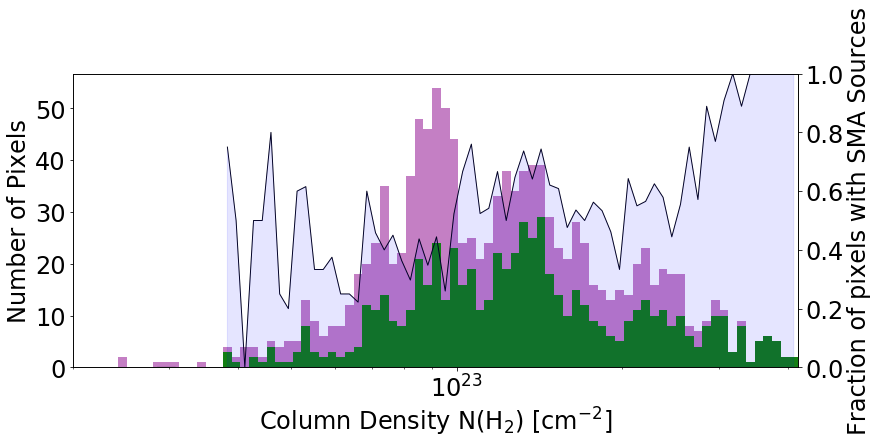

In [73]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16}) #set fontsize

# Plot Histogram
plt.rcParams.update({'font.size': 24}) #set fontsize
histfig = plt.figure(3,figsize=(13,6))
histfig.clf()
ax = histfig.gca()
plt.ylabel('Number of Pixels')
plt.xlabel('Column Density N(H$_2$) [cm$^{-2}$]')
#plt.legend(loc='upper left', shadow=False, fontsize=18)

#bins = np.logspace(22.9,23.9,100)
linbins = np.linspace(colmin, colmax,100)
logbins = np.logspace(np.log10(colmin), np.log10(colmax),100)
### histogram non sources
#h1,l1,p1 = ax.hist(column_masked[np.isfinite(column_masked) & ~sb2_mask],
#                   logbins, color='black',alpha=0.5, log=False,
#                   label='Full cloud')
### histogram all sources
h2,l2,p2 = ax.hist(column_masked[smasourcemask & np.isfinite(column_masked) &
                                 ~sb2_mask], logbins, alpha=0.5, log=False, color='darkmagenta',
                   label='SMA Sources')
### histogram non sf 
#h3,l3,p3 = ax.hist(column_masked[smasourcemask_nsf & np.isfinite(column_masked) &
#                                 ~sb2_mask], logbins, alpha=.7, log=False, color='orange',
#                   label='SMA Sources')
### histogram sf
h4,l4,p4 = ax.hist(column_masked[smasourcemask_sf & np.isfinite(column_masked) &
                                 ~sb2_mask], logbins, alpha=.9, log=False, color='green',
                   label='SMA Sources')

ax3 = ax.twinx()
midpts = (l1[:-1] + l1[1:])/2.
line_frac = ax3.plot(midpts, h4/h2, linestyle='-', color='k', linewidth=0.95, zorder=-21,label='Fraction of source pixels with SF tracers')
ax3.set_ylabel("Fraction of pixels with SMA Sources")
ax3.set_ylim(0,1)
fill = ax3.fill_between(midpts,h4/h2, color='blue',alpha=0.1)
ax3.set_label('Fraction of pixels with SMA Sources')
#ax.legend(line_frac,'Fraction of pixels with SMA Sources')
#ax3.legend(loc='upper right', shadow=False, fontsize=18)



ax.set_xscale("log")
#ax.set_xlim(10**22.9, 10**23.9)
ax.set_xlim(2e22, colmax)
#ax.set_ylim(1,380)
#ax.set_ylim(1,5000)
plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis



# Save figure
# Need to save it as a PDF, otherewise, lose transparency
#plt.savefig(figure_path + 'column_histograms_log'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')

plt.show()

/Users/hph/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in divide
/Users/hph/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in divide


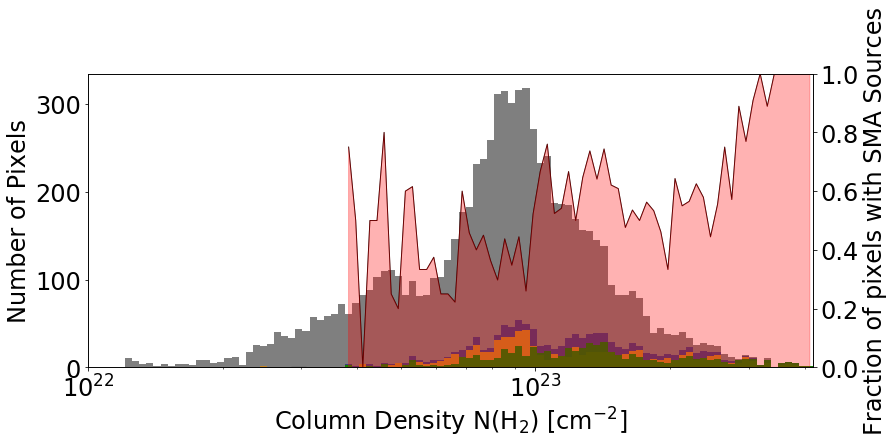

In [74]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16}) #set fontsize

# Plot Histogram
plt.rcParams.update({'font.size': 24}) #set fontsize
histfig = plt.figure(3,figsize=(13,6))
histfig.clf()
ax = histfig.gca()
plt.ylabel('Number of Pixels')
plt.xlabel('Column Density N(H$_2$) [cm$^{-2}$]')
#plt.legend(loc='upper left', shadow=False, fontsize=18)

#bins = np.logspace(22.9,23.9,100)
linbins = np.linspace(colmin, colmax,100)
logbins = np.logspace(np.log10(colmin), np.log10(colmax),100)
### histogram non sources
h1,l1,p1 = ax.hist(column_masked[np.isfinite(column_masked) & ~sb2_mask],
                   logbins, color='black',alpha=0.5, log=False,
                   label='Full cloud')
### histogram all sources
h2,l2,p2 = ax.hist(column_masked[smasourcemask & np.isfinite(column_masked) &
                                 ~sb2_mask], logbins, alpha=0.5, log=False, color='navy',
                   label='SMA Sources')
### histogram non sf 
h3,l3,p3 = ax.hist(column_masked[smasourcemask_nsf & np.isfinite(column_masked) &
                                 ~sb2_mask], logbins, alpha=.7, log=False, color='orange',
                   label='SMA Sources')
### histogram sf
h4,l4,p4 = ax.hist(column_masked[smasourcemask_sf & np.isfinite(column_masked) &
                                 ~sb2_mask], logbins, alpha=.9, log=False, color='green',
                   label='SMA Sources')

ax3 = ax.twinx()
midpts = (l1[:-1] + l1[1:])/2.
line_frac = ax3.plot(midpts, h4/h2, linestyle='-', color='k', linewidth=0.95, zorder=-21,label='Fraction of source pixels with SF tracers')
ax3.set_ylabel("Fraction of pixels with SMA Sources")
ax3.set_ylim(0,1)
fill = ax3.fill_between(midpts,h4/h2, color='red',alpha=0.3)
ax3.set_label('Fraction of pixels with SMA Sources')
#ax.legend(line_frac,'Fraction of pixels with SMA Sources')
#ax3.legend(loc='upper right', shadow=False, fontsize=18)



ax.set_xscale("log")
#ax.set_xlim(10**22.9, 10**23.9)
ax.set_xlim(1e22, colmax)
#ax.set_ylim(1,380)
#ax.set_ylim(1,5000)
plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis



# Save figure
# Need to save it as a PDF, otherewise, lose transparency
#plt.savefig(figure_path + 'column_histograms_log'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')

plt.show()

In [44]:
### reproject dendrogram mask for daniel
from reproject import reproject_interp
### load mask:
mask_hdu = fits.open(path + 'dendrogram_mask_pruned'+targetname)
### load fk5 image
alma_fits = fits.open('/Users/hph/temp/SgrB2_selfcal_full_TCTE7m_try2_selfcal6_ampphase_robust-1.image.tt0.pbcor.fits')
array, footprint = reproject_interp(mask_hdu, alma_fits[0].header)

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
